# IoT Data Modeling Demo using Sayo Pillow Data

#### Checks

In [2]:
spark

In [3]:
!nvidia-smi

Fri Apr 26 18:34:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A10G                Off  | 00000000:00:1E.0 Off |                    0 |
|  0%   21C    P8     9W / 300W |      0MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### We want to see how long the notebook takes to run

In [4]:
import time
start_time = time.time()

## Installing the necessary libraries for the workflow

In [5]:
# Time check for installing libraries
start_time1 = time.time()

In [6]:
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install seaborn -q
!pip install mlxtend -q
!pip install fsspec -q
!pip install s3fs -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3transfer 0.8.2 requires botocore<2.0a.0,>=1.33.2, but you have botocore 1.27.59 which is incompatible.
boto3 1.33.13 requires botocore<1.34.0,>=1.33.13, but you have botocore 1.27.59 which is incompatible.


In [7]:
end_time1 = time.time()
elapsed_time1 = (end_time1 - start_time1)
print("Elapsed time to install libraries: {:.2f} seconds".format(elapsed_time1))

Elapsed time to install libraries: 36.31 seconds


## Importing the libraries for Reading the data, EDA and Data Visualization

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import fsspec
import s3fs
import os

## Loading the file from s3 bucket and converting it to a dataframe.

In [9]:
synutils.fs.download('syntasa-gov-sandbox-01/syn-workspace/users/mzaun/workspace/development/SaYoPillow.csv','/tmp/train.csv')

In [10]:
df=pd.read_csv('/tmp/train.csv')

In [11]:
df.head(1)

sr     rr      t    lm     bo   rem  sr.1    hr  sl
0  93.8  25.68  91.84  16.6  89.84  99.6  1.84  74.2   3

### About the dataset

<b>Dataset used:</b> Smart Yoga Pillow Dataset

<b>Aim:</b> Finding pattern between different body phenomenons and Stress 

<b>Features: </b>

* sr=snoring range
* rr=respiration rate
* bo=blood oxygen range
* rem=eye movement rate
* lm=limb movement rate
* t=temperature
* sr.1:hours of sleep
* hr:heart rate

<b>Label:</b>

sl=stress level

* 0:low/normal
* 1:medium low
* 2:medium
* 3:medium/high
* 4:high

## Data Preprocessing

### Checking for null and duplicate data values

In [12]:
df.isnull().sum()

sr      0
rr      0
t       0
lm      0
bo      0
rem     0
sr.1    0
hr      0
sl      0
dtype: int64

In [13]:
df.duplicated().any()

False

### Checking if the label count is similar

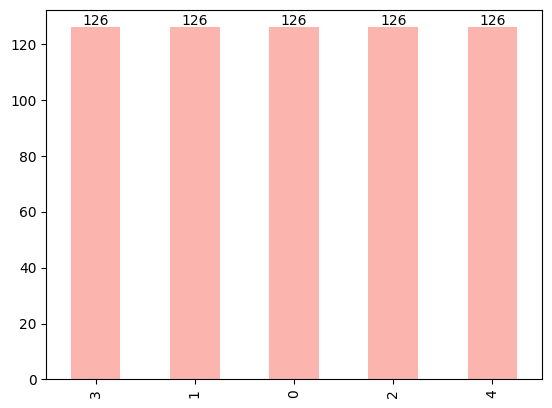

In [14]:
ax=df['sl'].value_counts().plot(kind='bar',cmap='Pastel1')
for bars in ax.containers:
    ax.bar_label(bars)

### Finding relationship between features and labels

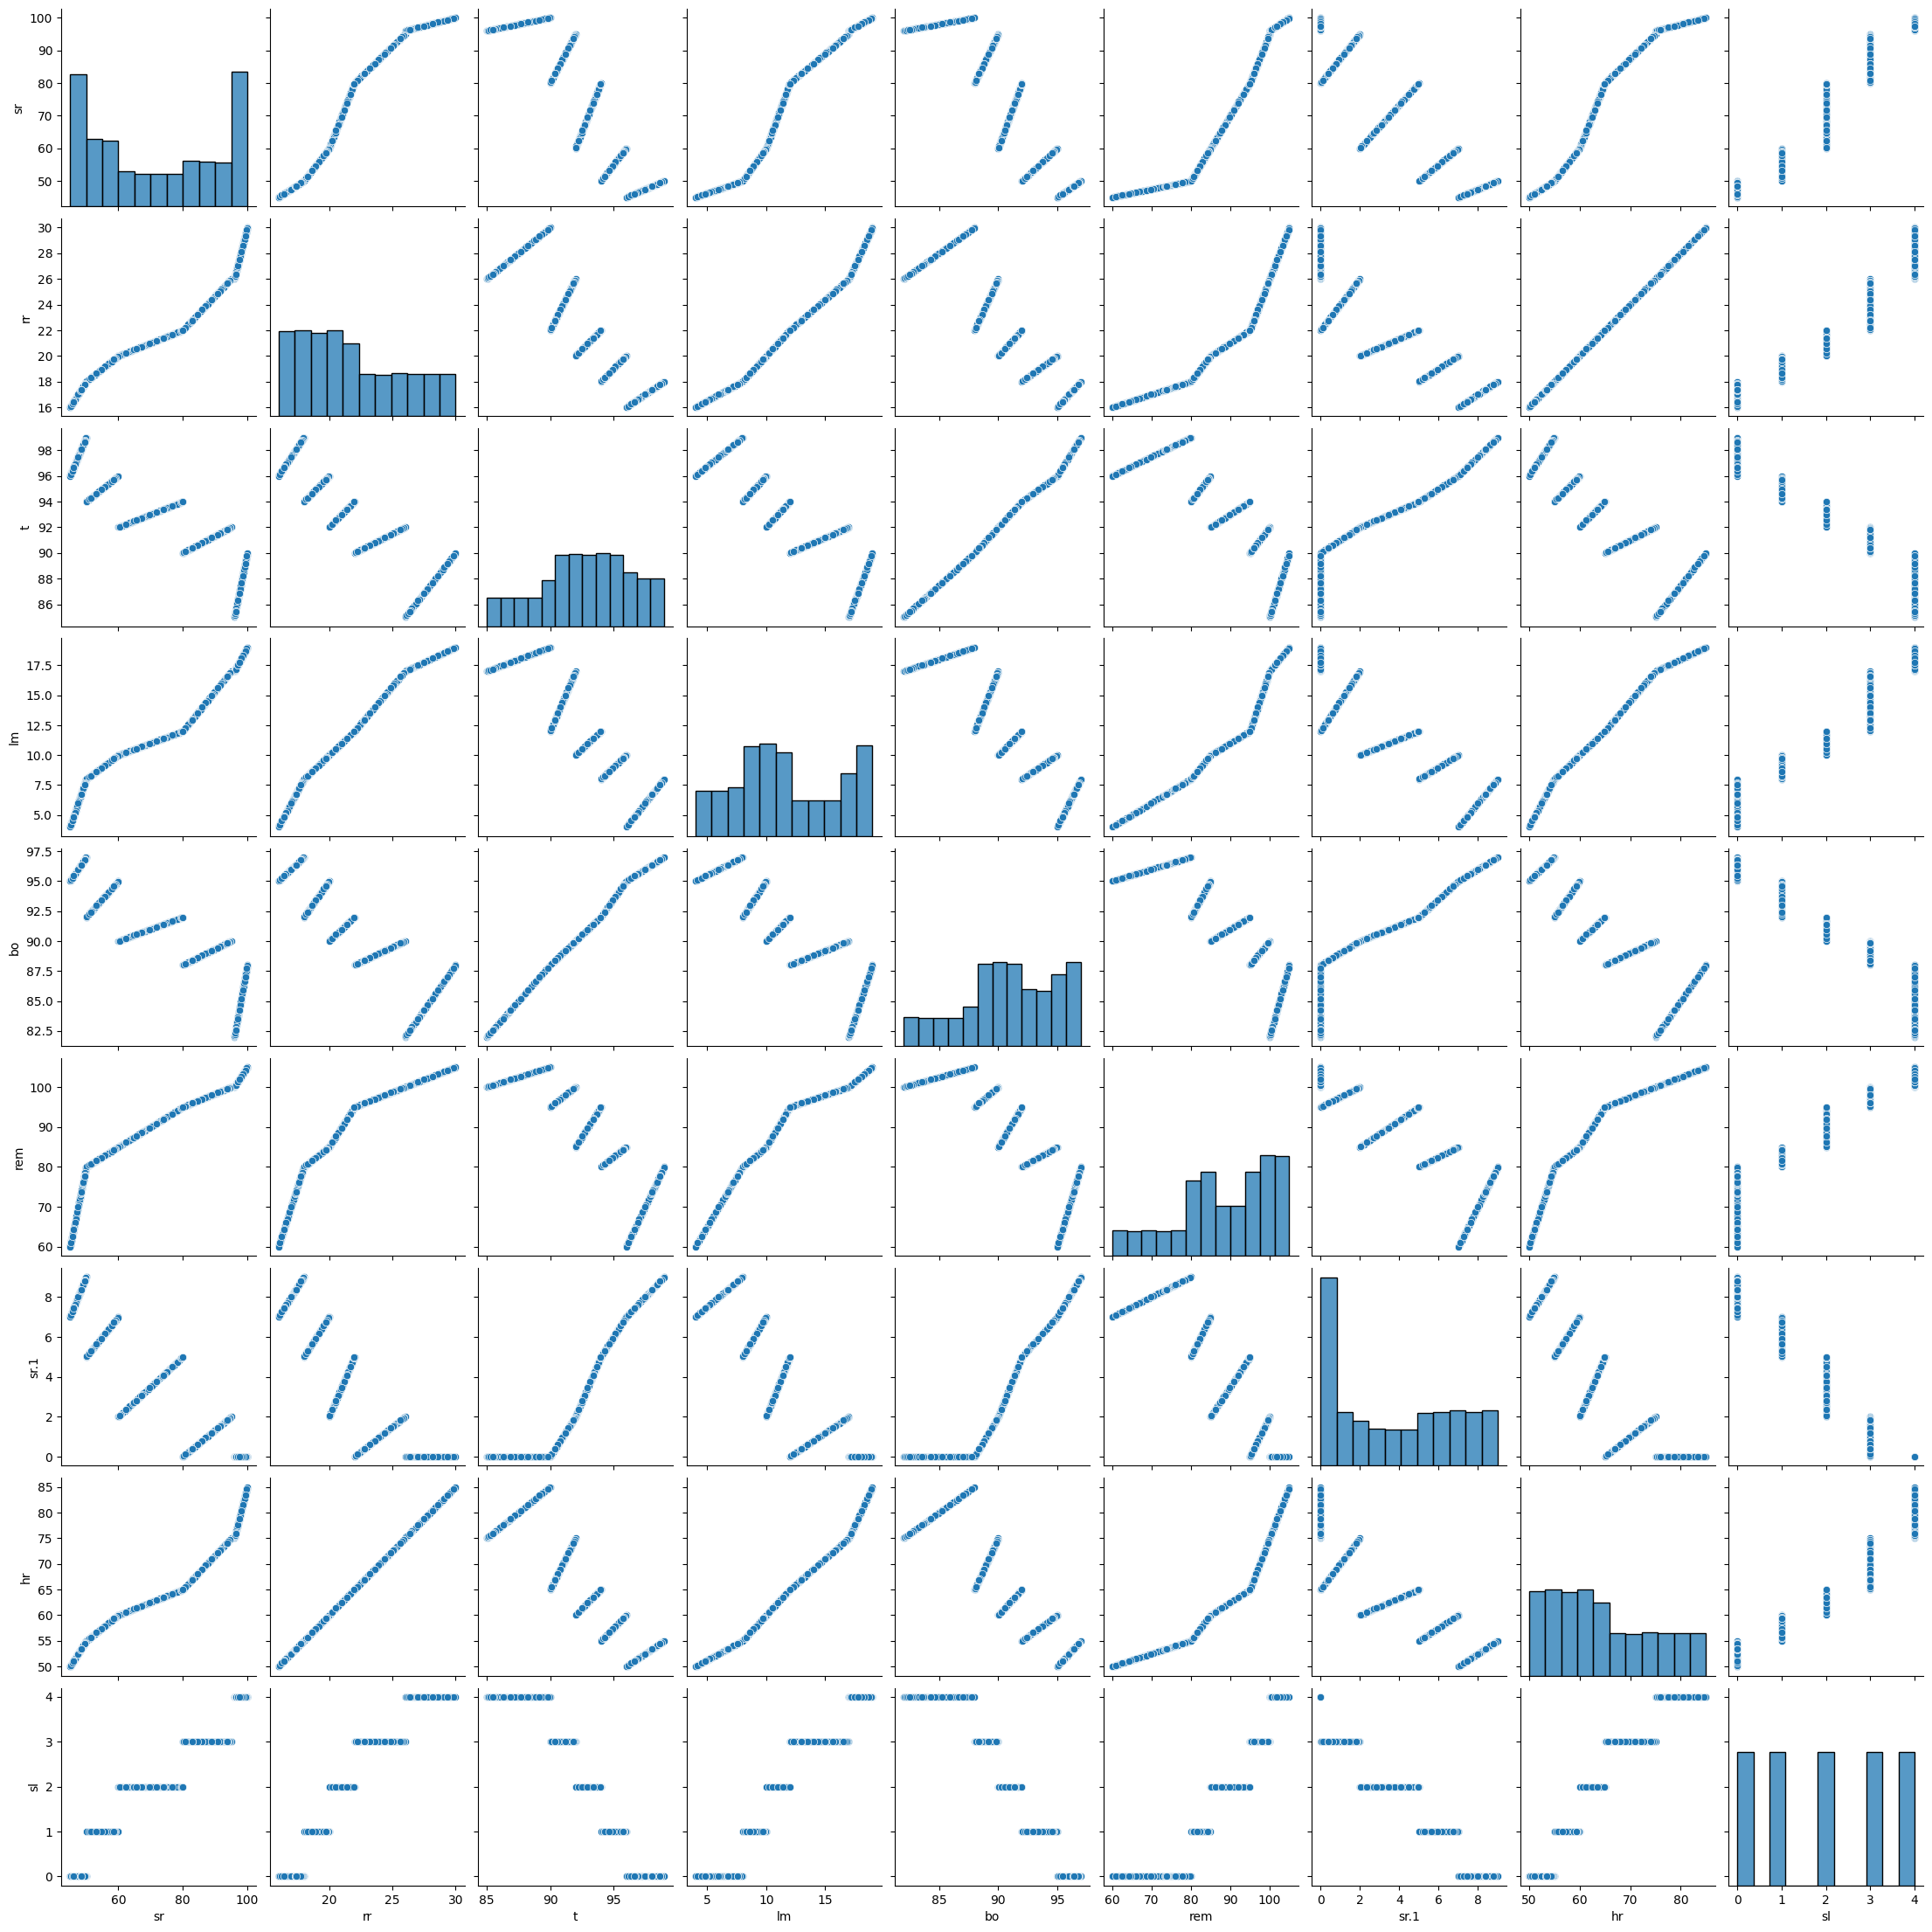

In [15]:
sns.pairplot(df)

<AxesSubplot:xlabel='sr', ylabel='rr'>

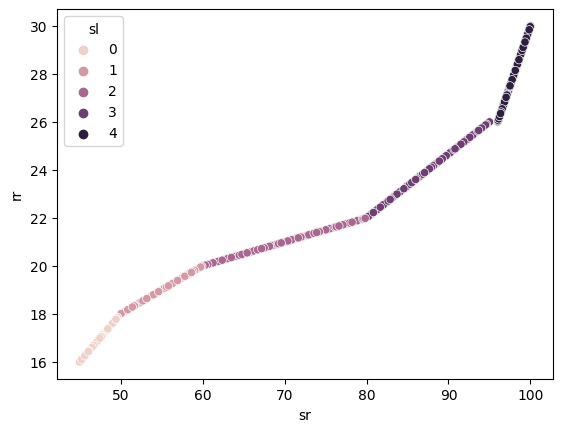

In [16]:
sns.scatterplot(x='sr',y='rr',hue='sl',data=df)

### Insight from above plot: respiration rate and snoaring rate increases with stress

<AxesSubplot:xlabel='t', ylabel='lm'>

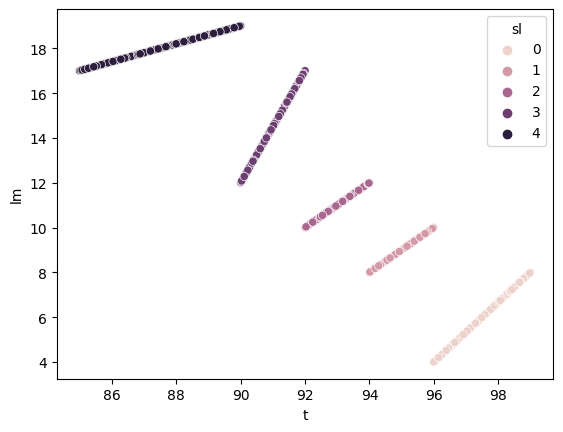

In [17]:
sns.scatterplot(x='t',y='lm',hue='sl',data=df)

### Insight from above plot: 
1. Limb Movement Increases with Increase in Stress Level.
2. Body Temperature falls with Increase in Stress Level

In [18]:
sns.scatterplot(x='bo',y='rem',hue='sl',data=df)

<AxesSubplot:xlabel='bo', ylabel='rem'>

### Insights from this plot:
1. Stress level is inversely proportional to blood oxygen level where max value of blood oxygen is 97.
2. Eye movement rate is more if stress is high.

<AxesSubplot:xlabel='sr.1', ylabel='hr'>

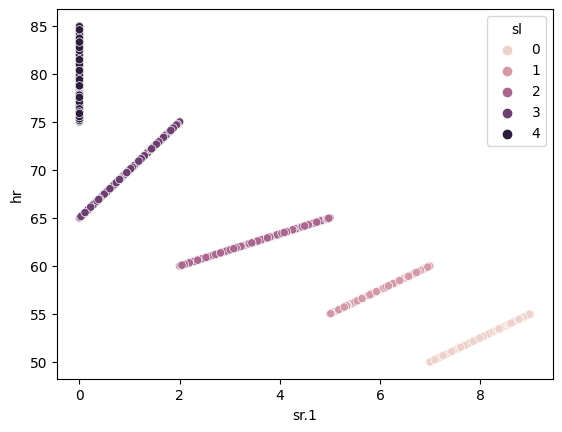

In [19]:
sns.scatterplot(x='sr.1',y='hr',hue='sl',data=df)

### Insights from this plot:
1. Heart rate is more if stress level is high.
2. Stress level is high if hours of sleep is low.

### Computing Feature Importance

In [20]:
from sklearn.feature_selection import SelectKBest,f_classif

In [21]:
X=df.drop(columns='sl')

In [22]:
y=df['sl']

In [23]:
k_best=SelectKBest(score_func=f_classif,k=X.shape[1])

In [24]:
k_best.fit(X,y)

SelectKBest(k=8)

In [25]:
feature_df=pd.DataFrame({'Features':X.columns,'Importance':k_best.scores_})

In [26]:
feature_df

Features   Importance
0       sr  4357.579640
1       rr  3137.303150
2        t  2338.935724
3       lm  3057.216610
4       bo  2305.221716
5      rem  2110.257617
6     sr.1  3937.007874
7       hr  3137.303150

### Visualizing the feature importances

In [27]:
plt.figure(figsize=(20,10))
ax=feature_df.plot(kind='barh',cmap='Pastel1')
plt.legend(bbox_to_anchor=(1.3,1))
for bars in ax.containers:
    ax.bar_label(bars)
    

<Figure size 2000x1000 with 0 Axes>

### We will find correlation between the features using seaborn's Heatmap

In [28]:
df.corr()

sr        rr         t        lm        bo       rem      sr.1  \
sr    1.000000  0.976268 -0.902475  0.981078 -0.903140  0.950600 -0.920554   
rr    0.976268  1.000000 -0.889237  0.991738 -0.889210  0.935572 -0.891855   
t    -0.902475 -0.889237  1.000000 -0.896412  0.998108 -0.857299  0.954860   
lm    0.981078  0.991738 -0.896412  1.000000 -0.898527  0.964703 -0.901102   
bo   -0.903140 -0.889210  0.998108 -0.898527  1.000000 -0.862136  0.950189   
rem   0.950600  0.935572 -0.857299  0.964703 -0.862136  1.000000 -0.893952   
sr.1 -0.920554 -0.891855  0.954860 -0.901102  0.950189 -0.893952  1.000000   
hr    0.976268  1.000000 -0.889237  0.991738 -0.889210  0.935572 -0.891855   
sl    0.975322  0.963516 -0.962354  0.971071 -0.961092  0.951988 -0.973036   

            hr        sl  
sr    0.976268  0.975322  
rr    1.000000  0.963516  
t    -0.889237 -0.962354  
lm    0.991738  0.971071  
bo   -0.889210 -0.961092  
rem   0.935572  0.951988  
sr.1 -0.891855 -0.973036  
hr    1.000000  0.963516  
sl    0.963516  1.000000

<AxesSubplot:>

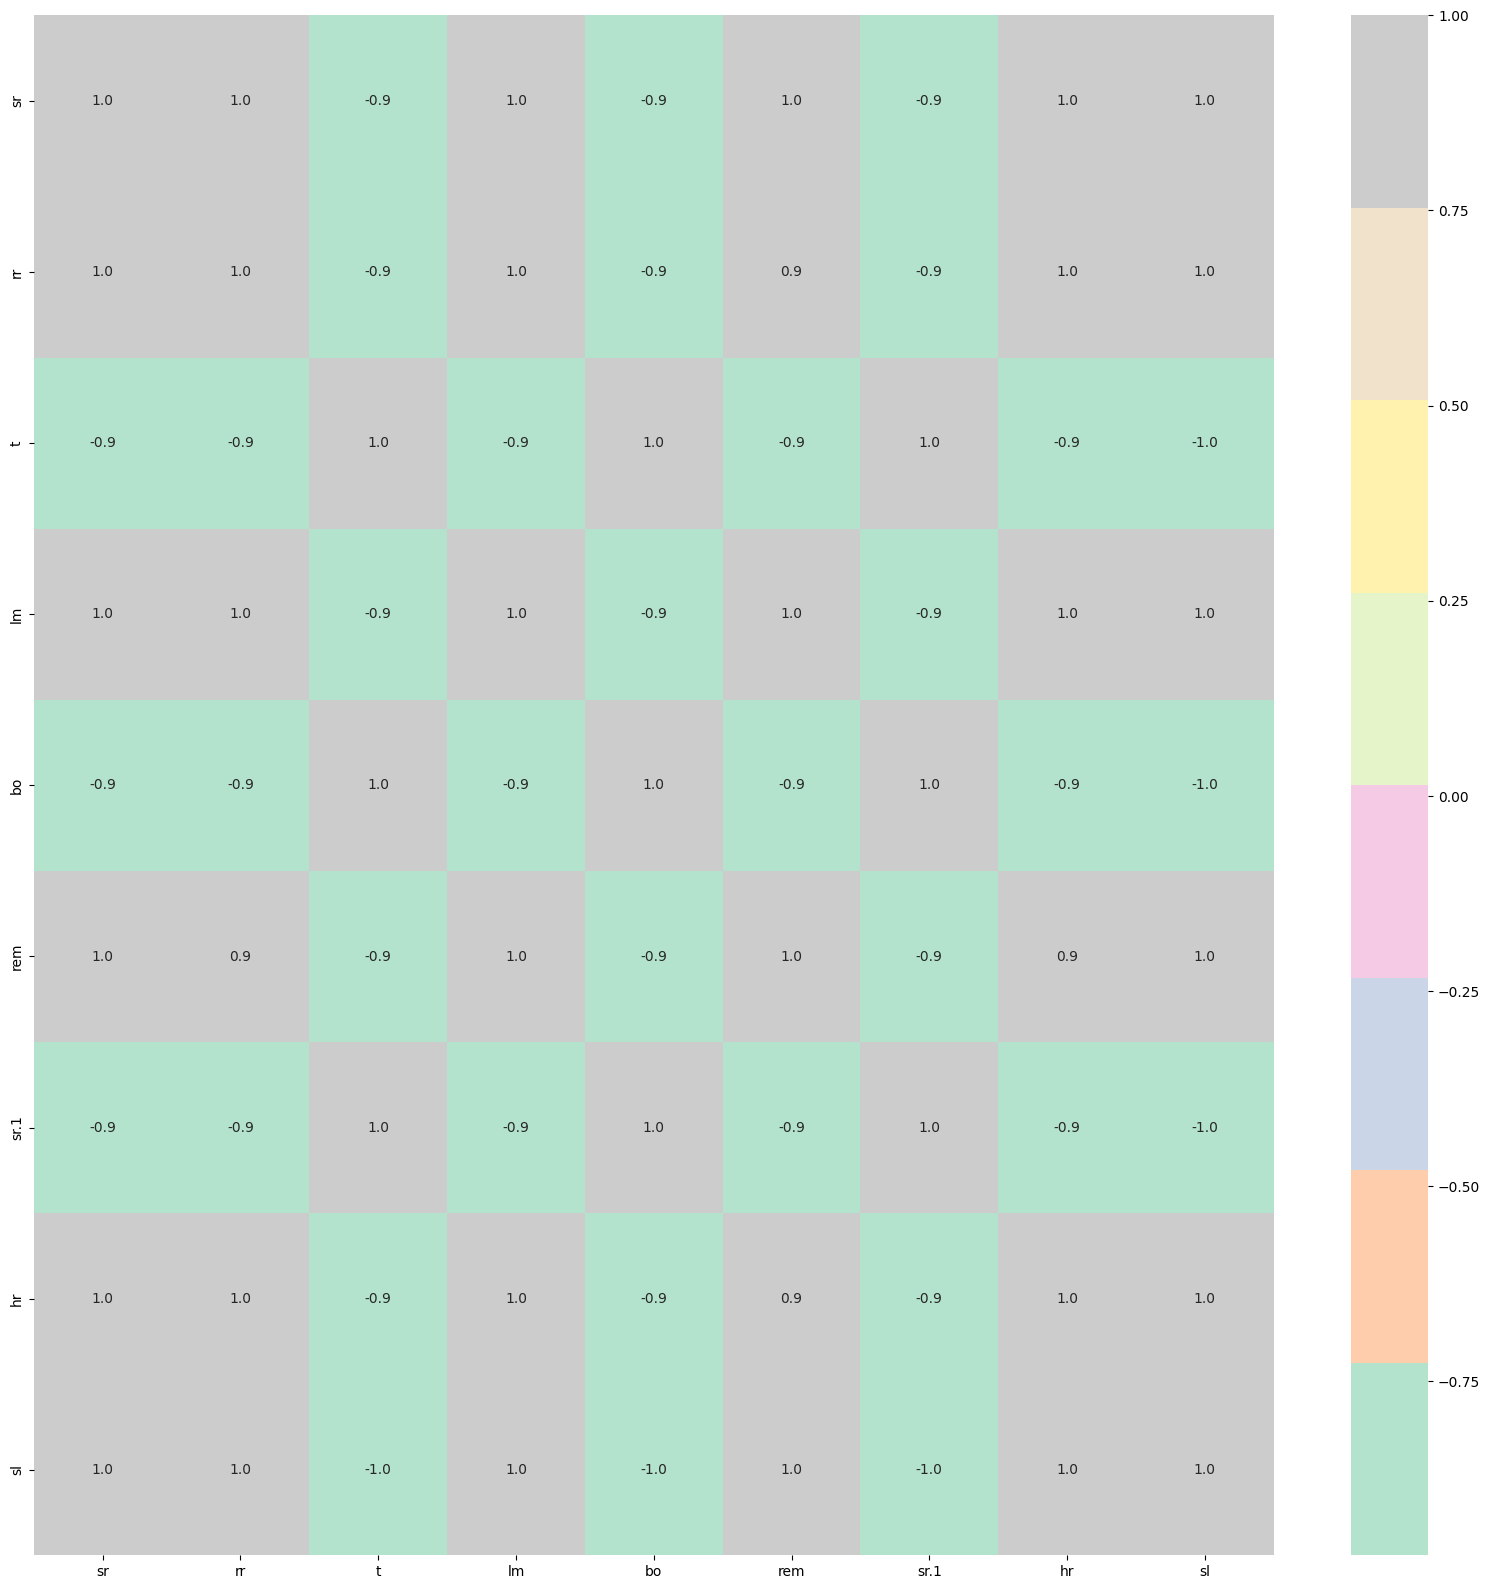

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,fmt='0.1f',cmap='Pastel2')

### This plot shows that there is high correlation between the features so we can drop some features which are having high correlation.

In [30]:
new_df=df[['sr','sr.1','sl']]

In [31]:
sns.scatterplot(x='sr',y='sr.1',hue='sl',data=new_df)

<AxesSubplot:xlabel='sr', ylabel='sr.1'>

<AxesSubplot:>

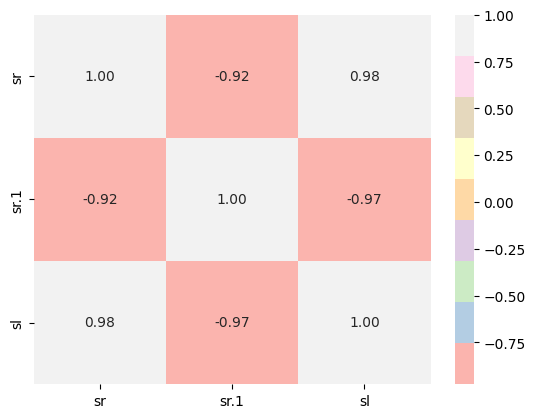

In [32]:
sns.heatmap(new_df.corr(),annot=True,fmt='0.2f',cmap='Pastel1')

### Now the features are not correlated. Next step is to Remove Outliers and Normalize the data.

In [33]:
new_df.describe()

sr        sr.1          sl
count  630.000000  630.000000  630.000000
mean    71.600000    3.700000    2.000000
std     19.372833    3.054572    1.415337
min     45.000000    0.000000    0.000000
25%     52.500000    0.500000    1.000000
50%     70.000000    3.500000    2.000000
75%     91.250000    6.500000    3.000000
max    100.000000    9.000000    4.000000

<AxesSubplot:xlabel='sr', ylabel='Density'>

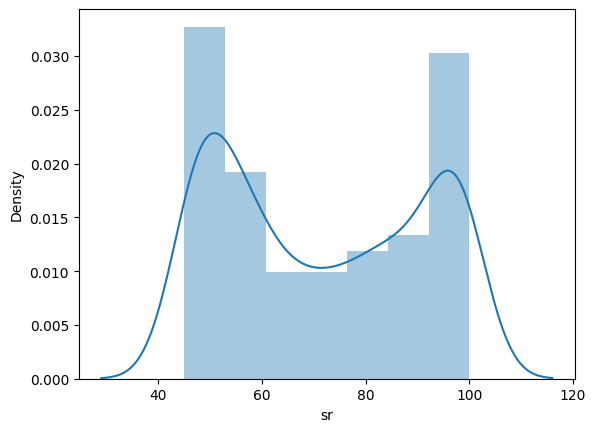

In [34]:
sns.distplot(new_df['sr'])

<AxesSubplot:xlabel='sr.1', ylabel='Density'>

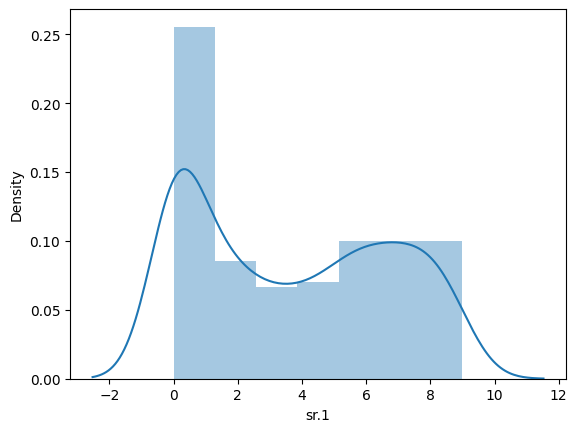

In [35]:
sns.distplot(new_df['sr.1'])

<AxesSubplot:>

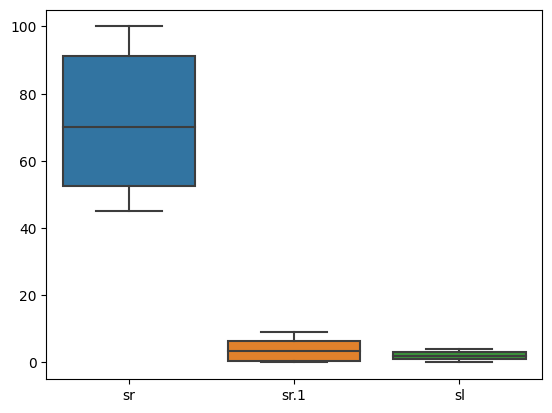

In [36]:
sns.boxplot(new_df)

### There are no outliers in the dataset

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
s=StandardScaler()

## Train Test Split

In [39]:
from sklearn.model_selection import train_test_split,GridSearchCV

In [40]:
X_train,X_test,y_train,y_test=train_test_split(new_df.drop(columns='sl'),new_df['sl'],test_size=0.2,random_state=42)

In [41]:
X_train=s.fit_transform(X_train)
X_test=s.transform(X_test)

In [42]:
sns.distplot(X_train)

<AxesSubplot:ylabel='Density'>

### Training our first model, Multi Layer Perceptron Classifier on the dataset.

In [43]:
from sklearn.neural_network import MLPClassifier

In [44]:
clf=MLPClassifier()

### Performing GridSearchCV to find the best values of hyperparameters.

In [45]:
params={'hidden_layer_sizes':[(32),(32,64),(32,64,128),(32,64,128,256)],'activation':['relu','tanh'],'solver':['adam','RMSprop']}

In [46]:
g=GridSearchCV(clf,param_grid=params,cv=10,scoring='accuracy')

In [47]:
g.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [32, (32, 64), (32, 64, 128),
                                                (32, 64, 128, 256)],
                         'solver': ['adam', 'RMSprop']},
             scoring='accuracy')

In [48]:
g.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (32, 64), 'solver': 'adam'}

In [49]:
g.best_score_

1.0

In [50]:
results=g.cv_results_

In [51]:
params=results['params']
mean_test_score=results['mean_test_score']

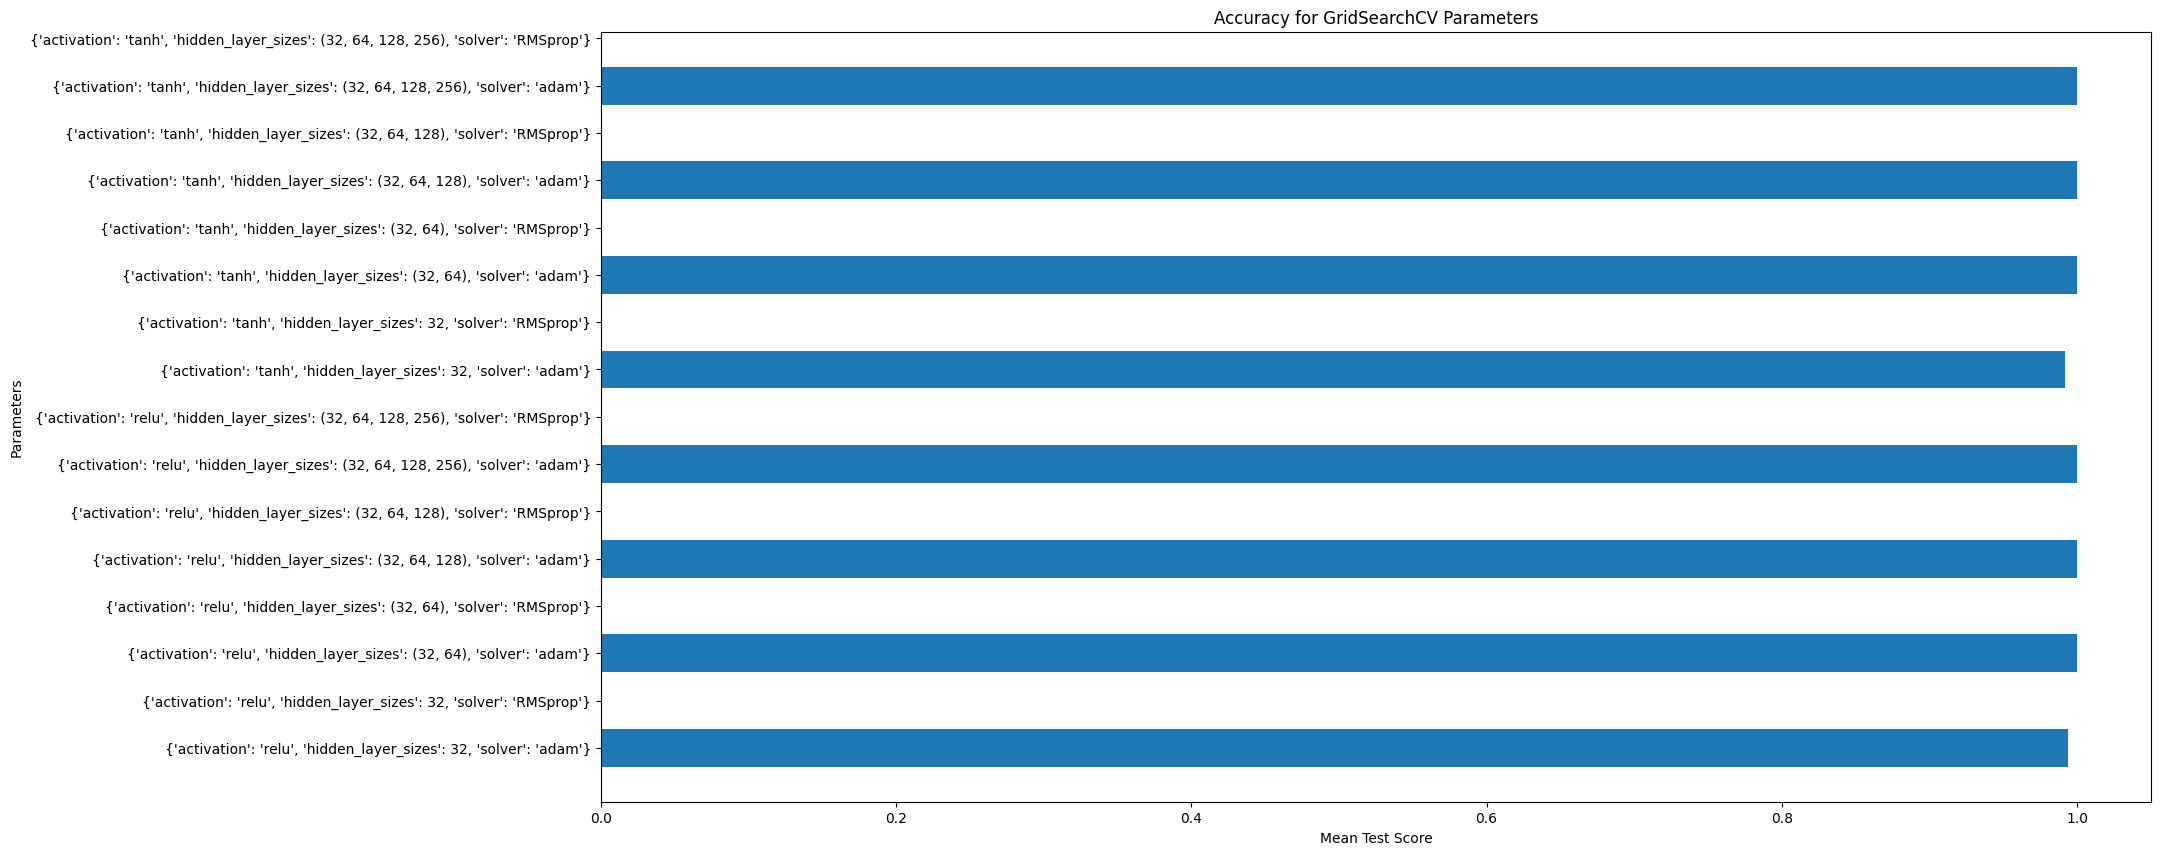

In [52]:
plt.figure(figsize=(20,10))
plt.barh(range(len(params)), mean_test_score, align='center')
plt.yticks(range(len(params)), [str(param) for param in params])
plt.xlabel('Mean Test Score')
plt.ylabel('Parameters')
plt.title('Accuracy for GridSearchCV Parameters')
plt.savefig('/tmp/hyperparameter_tuning.png')
plt.show()

In [53]:
from PIL import Image

In [54]:
img=Image.open('/tmp/hyperparameter_tuning.png')

### Training a new model with hyperparameter values returned by GridSearch method.

In [55]:
model=MLPClassifier(**g.best_params_)

In [56]:
model.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(32, 64))

### Making predictions and computing model metrics.

In [57]:
y_pred=model.predict(X_test)

In [58]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,accuracy_score,roc_auc_score,f1_score

In [59]:
a=accuracy_score(y_test,y_pred)

In [60]:
p=precision_score(y_test,y_pred,average='micro')

In [61]:
r=recall_score(y_test,y_pred,average='micro')

In [62]:
f=f1_score(y_test,y_pred,average='micro')

In [63]:
confusion_matrix(y_test,y_pred)

array([[23,  0,  0,  0,  0],
       [ 0, 24,  0,  0,  0],
       [ 0,  0, 28,  0,  0],
       [ 0,  0,  0, 26,  0],
       [ 0,  0,  0,  0, 25]])

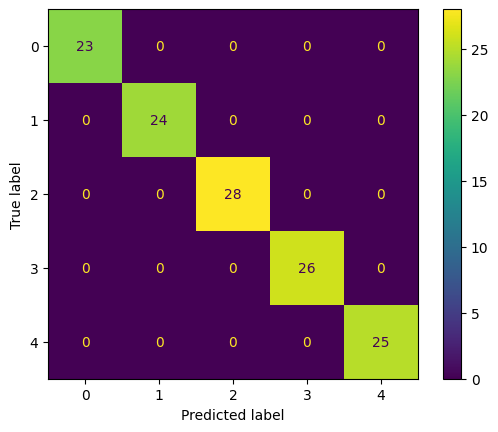

In [64]:
cmd=ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=model.classes_).plot()
plt.savefig('/tmp/cm_nn1.png')

In [65]:
cm_img=Image.open('/tmp/cm_nn1.png')

### The images are loaded for mlflow addition.

## Plot Decision Regions and saving the image for MLflow

In [66]:
from mlxtend.plotting import plot_decision_regions

In [67]:
X=np.vstack([X_train,X_test])
y=np.hstack([y_train,y_test])

In [68]:
plot_decision_regions(X,np.array(y),model)
plt.savefig('/tmp/pdr.png')

In [69]:
img_dr=Image.open('/tmp/pdr.png')

### Linking the model to mlflow for monitoring.

In [70]:
import mlflow
from mlflow.models import infer_signature

In [71]:
mlflow.set_experiment('Smart Yoga Pillow')

<Experiment: artifact_location='mlflow-artifacts:/21', creation_time=1714132927424, experiment_id='21', last_update_time=1714132927424, lifecycle_stage='active', name='Smart Yoga Pillow', tags={}>

In [72]:
g.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (32, 64), 'solver': 'adam'}

In [73]:
with mlflow.start_run():
    mlflow.log_param('Number of Hidden Layers',1)
    for key,values in g.best_params_.items():
        mlflow.log_param(key,values)
    mlflow.log_metric('Accuracy Score',a)
    mlflow.log_metric('Precision Score',p)
    mlflow.log_metric('Recall Score',p)
    mlflow.log_metric('F1_score',f)
    mlflow.log_image(img,'Feature_Importance.png')
    mlflow.log_image(cm_img,'Confusion_Matrix.png')
    mlflow.log_image(img_dr,'Decision_Regions.png')
    #info=mlflow.sklearn.log_model(sk_model=model,artifact_path='Classifier',registered_model_name='Stress_vs_Sleep')

### Time Check

In [74]:
end_time = time.time()
elapsed_time = (end_time - start_time)
print("Time to run the full notebook: {:.2f} seconds".format(elapsed_time))

Time to run the full notebook: 121.85 seconds
